In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from joblib import dump
from xgboost import XGBRegressor
import pandas as pd
from matplotlib import pyplot as plt


In [14]:

# --- 1. Carregando os CSVs ---
x_train = pd.read_csv('../data/processed/x_train_encoded.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

x_test = pd.read_csv('../data/processed/x_test_encoded.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def avaliar_modelo_final(model_class, best_params, x_train, y_train, x_test, y_test, n_runs=30, random_state_base=42):
    """
    Roda o modelo n_runs vezes e avalia no conjunto de teste.
    Retorna um DataFrame com as métricas de cada rodada.
    """
    resultados = []
    
    for i in range(n_runs):
        # Criar modelo com mesma config mas seeds diferentes
        model = model_class(random_state=random_state_base + i, **best_params)
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        resultados.append({"Run": i+1, "MAE": mae, "RMSE": rmse, "R2": r2})
    
    return pd.DataFrame(resultados)

# Exemplo de uso:
best_xgb_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8
}

resultados_test = avaliar_modelo_final(XGBRegressor, best_xgb_params, x_train, y_train, x_test, y_test, n_runs=30)

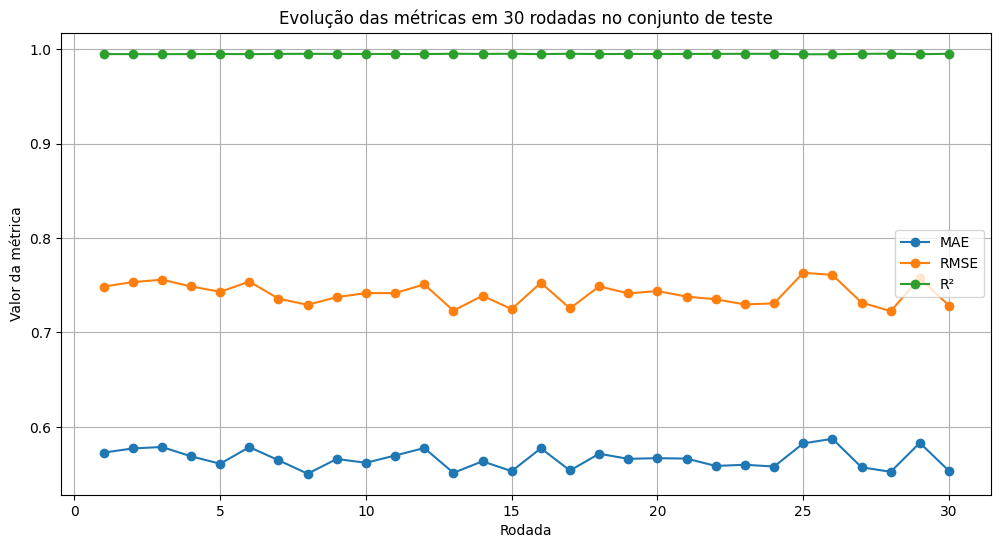

In [15]:
plt.figure(figsize=(12,6))
plt.plot(resultados_test['Run'], resultados_test['MAE'], marker='o', label='MAE')
plt.plot(resultados_test['Run'], resultados_test['RMSE'], marker='o', label='RMSE')
plt.plot(resultados_test['Run'], resultados_test['R2'], marker='o', label='R²')

plt.xlabel('Rodada')
plt.ylabel('Valor da métrica')
plt.title('Evolução das métricas em 30 rodadas no conjunto de teste')
plt.legend()
plt.grid(True)
plt.show()

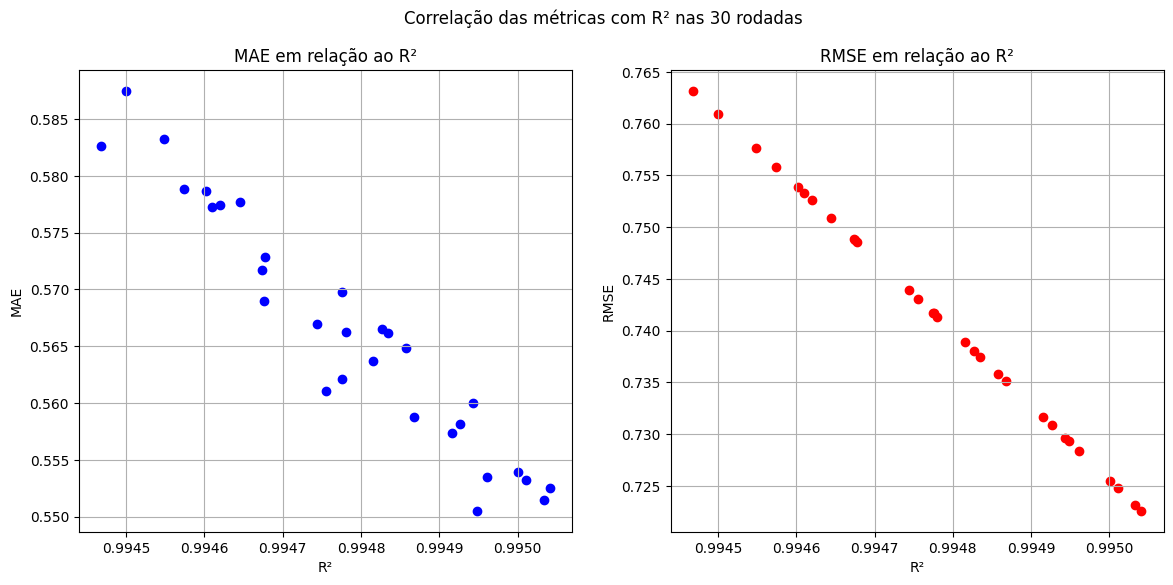

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].scatter(resultados_test['R2'], resultados_test['MAE'], color='blue', label='MAE vs R²')
ax[0].set_xlabel('R²')
ax[0].set_ylabel('MAE')
ax[0].set_title('MAE em relação ao R²')
ax[0].grid(True)

ax[1].scatter(resultados_test['R2'], resultados_test['RMSE'], color='red', label='RMSE vs R²')
ax[1].set_xlabel('R²')
ax[1].set_ylabel('RMSE')
ax[1].set_title('RMSE em relação ao R²')
ax[1].grid(True)

plt.suptitle('Correlação das métricas com R² nas 30 rodadas')
plt.show()

In [18]:
print(resultados_test.describe()[['MAE','RMSE','R2']])

             MAE       RMSE         R2
count  30.000000  30.000000  30.000000
mean    0.566448   0.741240   0.994780
std     0.010537   0.011737   0.000165
min     0.550519   0.722592   0.994468
25%     0.558289   0.731049   0.994652
50%     0.566204   0.741510   0.994778
75%     0.576149   0.750377   0.994924
max     0.587481   0.763184   0.995041


---
### Serializando o modelo

In [ ]:

# --- 1. Carregando os CSVs ---
x_train = pd.read_csv('../data/raw/test_split/x_train.csv')
y_train = pd.read_csv('../data/raw/test_split/y_train.csv')

x_test = pd.read_csv('../data/raw/test_split/x_test.csv')
y_test = pd.read_csv('../data/raw/test_split/y_test.csv')


In [7]:

# --- 2. Definindo colunas categóricas ---
col_one_hot = ['tipo_servico']
col_ordinal = [
    'mix_receita', 'parcerias', 'investimento_externo', 'branding_reputacao',
    'network_time', 'uso_tecnologia', 'roadmap_produto', 'eficiencia_operacional',
    'escala_tecnologica', 'financas_unidade', 'experiencia_lideranca',
    'treinamento', 'governanca_financeira'
]

# --- 3. Ordem das categorias para o OrdinalEncoder ---
ordinal_categories = [
    ['1–2 clientes >50%', '3–5 clientes >50%', 'Receita diversificada'],      
    ['Nenhuma', 'Poucas', 'Algumas', 'Muitas'],                               
    ['Não', 'Aceleradora/Anjo', 'Seed/Pré-Série A', 'Série A+'],              
    ['Não reconhecida', 'Algum reconhecimento', 'Reconhecimento forte'],      
    ['Não', 'Ocasionalmente', 'Sim, forte'],                                  
    ['Baixo', 'Médio', 'Alto'],                                               
    ['Não existe', 'Parcial', 'Claro e executado'],                           
    ['Quase nada', 'Parcialmente', 'Quase tudo'],                             
    ['Não', 'Parcialmente', 'Sim'],                                           
    ['Não', 'Algumas', 'Sim, regularmente'],                                  
    ['Sem experiência', 'Experiência parcial', 'Experiência forte'],          
    ['Nunca', 'Às vezes', 'Regularmente'],                                    
    ['Não existem controles', 'Controles básicos', 'DRE e auditoria']         
]

# --- 4. Criando encoders ---
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)

# --- 5. Criando pré-processador com normalização ---
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', one_hot_encoder, col_one_hot),
        ('ordinal', ordinal_encoder, col_ordinal),
        ('scaler', StandardScaler(), list(set(x_train.columns) - set(col_one_hot) - set(col_ordinal)))
    ],
    remainder='drop'
)

# --- Criar pipeline final com preprocessor + modelo ---
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        random_state=42,
        colsample_bytree=1.0,
        learning_rate=0.1,
        max_depth=3,
        n_estimators=300,
        subsample=0.8
    ))
])

# Treinar o pipeline inteiro com dados crus (sem pré-processamento manual antes)
final_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['tipo_servico']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['1–2 '
                                                                              'clientes '
                                                                              '>50%',
                                                                              '3–5 '
                                                                              'clientes '
                                                                              '>50%',
                                                                              'Receita '
                                                                              'diversificada'],
                                                                             ['Nenhuma',
                                                                              'Poucas',
                                                                              'Algumas',
                                                                              'Muitas'],
                                                                             ['Não',
                                                                              'Aceleradora/Anjo',
                                                                              'Seed/Pré-Série '
                                                                              'A',
                                                                              'Série '
                                                                              'A+'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [2]:
# Salvar o pipeline inteiro no arquivo .pkl
dump(final_model, 'modelo_startup.pkl')
print("Pipeline + Modelo salvo com sucesso em 'modelo_startup.pkl'")

Pipeline + Modelo salvo com sucesso em 'modelo_startup.pkl'


---
### Teste de Previsão usando o arquivo serializado

In [8]:
from joblib import load

# Carregar o pipeline salvo
modelo_carregado = load('modelo_startup.pkl')

# Exemplo de novos dados crus (sem pré-processar manualmente)
# Criar um DataFrame com os novos dados crus
dados_teste = pd.DataFrame({
    'clientes_ativos': [144],
    'faturamento_mensal': [1726047],
    'faturamento_acumulado': [339550],
    'anos_empresa': [0.2],
    'tipo_servico': ['Serviço'],
    'ticket_medio': [25935.5],
    'mix_receita': ['3–5 clientes >50%'],
    'canais_vendas': [5],
    'churn': [0.378],
    'parcerias': ['Algumas'],
    'investimento_externo': ['Série A+'],
    'branding_reputacao': ['Reconhecimento forte'],
    'network_time': ['Sim, forte'],
    'uso_tecnologia': ['Alto'],
    'roadmap_produto': ['Parcial'],
    'nps': [53],
    'eficiencia_operacional': ['Parcialmente'],
    'escala_tecnologica': ['Parcialmente'],
    'financas_unidade': ['Algumas'],
    'headcount': [10],
    'experiencia_lideranca': ['Experiência forte'],
    'treinamento': ['Às vezes'],
    'rotatividade_time': [0.447],
    'governanca_financeira': ['Não existem controles']
})
# Fazer previsão diretamente com dados crus (sem pré-processar manualmente!)
y_pred_novo = modelo_carregado.predict(dados_teste)
print("Previsão para novos dados:", y_pred_novo)

Previsão para novos dados: [42.642467]
